# Data Preprocessing with UCI Adult Dataset

shape: (48842, 15)

Missing Values:
age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64

 % of missing values:
age               0.000000
workclass         1.971664
fnlwgt            0.000000
education         0.000000
education-num     0.000000
marital-status    0.000000
occupation        1.977806
relationship      0.000000
race              0.000000
sex               0.000000
capital-gain      0.000000
capital-loss      0.000000
hours-per-week    0.000000
native-country    0.560993
income            0.000000
dtype: float64

Rows remaining after removing missing values: 47621

Data Types:
age                int64
workclass         object
fnlwgt             int64
education         object
education-nu

C:\Users\shive\AppData\Local\Temp\ipykernel_2620\2661017084.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[column] = label_encoders[column].fit_transform(df_clean[column])
C:\Users\shive\AppData\Local\Temp\ipykernel_2620\2661017084.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[column] = label_encoders[column].fit_transform(df_clean[column])
C:\Users\shive\AppData\Local\Temp\ipykernel_2620\2661017084.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

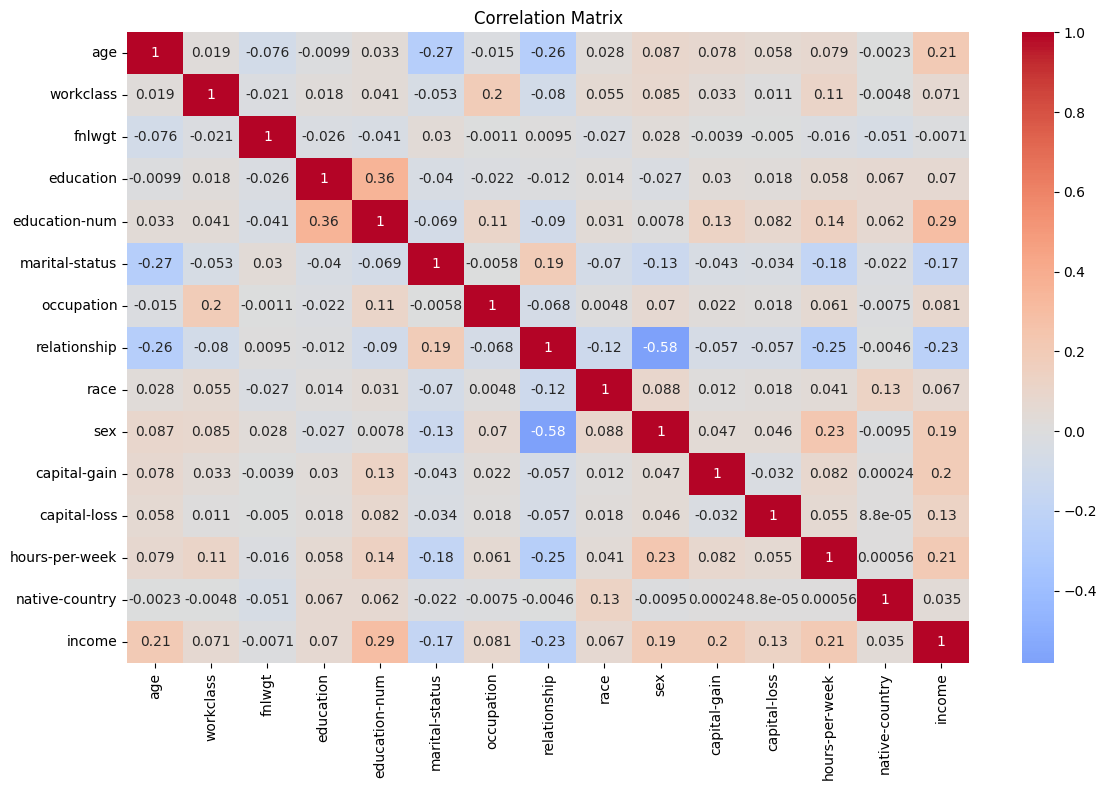


Final processed data shapes:
X shape: (47592, 14)
y shape: (47592,)

Processed dataframe saved as 'processed_adult.csv'.

Dataset Metadata:
{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

adult = fetch_ucirepo(id=2)

X = adult.data.features
y = adult.data.targets

def preprocess_data(X, y):

    df = pd.concat([X, y], axis=1)
    print("shape:", df.shape)


    print("\nMissing Values:")
    print(df.isnull().sum())
    

    missing_percentages = (df.isnull().sum() / len(df)) * 100
    print("\n % of missing values:")
    print(missing_percentages)


    df_clean = df.dropna()
    print(f"\nRows remaining after removing missing values: {len(df_clean)}")


    print("\nData Types:")
    print(df_clean.dtypes)


    numeric_columns = df_clean.select_dtypes(include=['int64', 'float64']).columns
    categorical_columns = df_clean.select_dtypes(include=['object', 'category']).columns

    label_encoders = {}
    for column in categorical_columns:
        label_encoders[column] = LabelEncoder()
        df_clean[column] = label_encoders[column].fit_transform(df_clean[column])


    scaler = StandardScaler()
    df_clean[numeric_columns] = scaler.fit_transform(df_clean[numeric_columns])


    initial_rows = len(df_clean)
    df_clean = df_clean.drop_duplicates()
    print(f"\nDuplicate rows removed: {initial_rows - len(df_clean)}")


    print("\nBasic Statistics:")
    print(df_clean.describe())

    plt.figure(figsize=(12, 8))
    sns.heatmap(df_clean.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()


    target_column = y.columns[0]
    X_processed = df_clean.drop(columns=[target_column])
    y_processed = df_clean[target_column]

    return X_processed, y_processed


X_processed, y_processed = preprocess_data(X, y)

print("\nFinal processed shapes:")
print("X shape:", X_processed.shape)
print("y shape:", y_processed.shape)


processed_df = pd.concat([X_processed, y_processed], axis=1)
processed_df.to_csv("processed_adult.csv", index=False)
print("\nProcessed dataframe processed_adult.csv.")


print("\nDataset data:")
print(adult.metadata)

print("\nVariable Info:")
print(adult.variables)


# Random Forest Classification on Processed Data

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

df = pd.read_csv("processed_adult.csv")

print(df['income'].value_counts())


# the dataset treats 0 and 1 as <=50K, and 2 and 3 as >50K . if not done this way then accuracy suffers
def map_income(val):
    if val == 0 or val == 1:
        return 0
    else:
        return 2

df['income_mapped'] = df['income'].apply(map_income)

X = df.drop(columns=['income', 'income_mapped'])
y = df['income_mapped']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

for n in [10, 50, 100, 200]:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print(f"\nRandom Forest with estimators={n}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))


income
0    24698
1    11355
2     7839
3     3700
Name: count, dtype: int64

Random Forest with estimators=10
Accuracy: 0.8505095073011871
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90      7211
           2       0.74      0.59      0.66      2308

    accuracy                           0.85      9519
   macro avg       0.81      0.76      0.78      9519
weighted avg       0.84      0.85      0.84      9519


Random Forest with estimators=50
Accuracy: 0.8555520537871625
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.91      7211
           2       0.74      0.62      0.68      2308

    accuracy                           0.86      9519
   macro avg       0.81      0.78      0.79      9519
weighted avg       0.85      0.86      0.85      9519


Random Forest with estimators=100
Accuracy: 0.8569177434604476
Classification Report:
        